<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/FlappyBird_ReinforcementLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries

### 1. Import the pygame environment

In [23]:
import os
!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
os.chdir('PyGame-Learning-Environment')
!pip install -e .
!pip install pygame
os.chdir('/content')

import pygame

Cloning into 'PyGame-Learning-Environment'...
remote: Enumerating objects: 1118, done.
remote: Total 1118 (delta 0), reused 0 (delta 0), pack-reused 1118
Receiving objects: 100% (1118/1118), 8.06 MiB | 31.37 MiB/s, done.
Resolving deltas: 100% (592/592), done.
Obtaining file:///content/PyGame-Learning-Environment
  Running setup.py develop for ple
     |████████████████████████████████| 11.4MB 2.8MB/s 
pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [0]:
import sys

## Step 1: Load data from google drive

In [25]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 1. Copy data from google drive to colab

In [0]:
# Copy data from google drive to Colab
!cp -r "/content/drive/My Drive/Deep Learning projects/FlappyBird" "/content"

## Step 2: Define the flappy_bird_utils

In [0]:
def load():
  
  # path of background
  background_path = "/content/FlappyBird/assets/sprites/background-black.png"
  
  # path of pipe
  pipe_path = "/content/FlappyBird/assets/sprites/pipe-green.png"
  
  images, hitmasks = {}, {}

  # numbers of sprites for score display
  images["numbers"] = (
      pygame.image.load("/content/FlappyBird/assets/sprites/0.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/1.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/2.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/3.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/4.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/5.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/6.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/7.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/8.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/9.png").convert_alpha()
  )
  
  # base  
  images["base"] = pygame.image.load("/content/FlappyBird/assets/sprites/base.png").convert_alpha()
  
  # select random background sprites
  images['background'] = pygame.image.load(background_path).convert()
    
    
  # select random player sprites
  images["player"] = (
      pygame.image.load("/content/FlappyBird/assets/sprites/redbird-upflap.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/redbird-midflap.png").convert_alpha(),
      pygame.image.load("/content/FlappyBird/assets/sprites/redbird-downflap.png").convert_alpha()   
  )
  
  images["pipe"] = (
    pygame.transform.rotate(
      pygame.image.load(pipe_path).convert_alpha(), 180),   
    pygame.image.load(pipe_path).convert_alpha()
  )
  
  
  # hitmask for pipes
  hitmasks["pipe"] = (
      getHitmask(images["pipe"][0]),
      getHitmask(images["pipe"][1]),
  )
  
  # hitmask for player
  hitmasks['player'] = (
      getHitmask(images['player'][0]),
      getHitmask(images['player'][1]),
      getHitmask(images['player'][2]),
  )
    
  return images, hitmasks

def getHitmask(image):
  mask = []
  for x in range(image.get_width()):
    mask.append([])
    for y in range(image.get_height()):
      mask[x].append(bool(image.get_at((x, y))[3]))
      
  return mask


## Step 3: Define the wrapped_flappy_bird

In [0]:
import numpy as np
import random
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

In [86]:
fps = 30
screenwidth = 288
screenheight = 512

pygame.init()
os.environ["SDL_VIDEODRIVER"] = "dummy"

fpsclock = pygame.time.Clock()
screen = pygame.display.set_mode((screenwidth, screenheight))
pygame.display.set_caption('Flappy Bird')

images, hitmasks = load()
images

{'background': <Surface(288x512x8 SW)>,
 'base': <Surface(336x112x32 SW)>,
 'numbers': (<Surface(24x36x32 SW)>,
  <Surface(16x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>,
  <Surface(24x36x32 SW)>),
 'pipe': (<Surface(52x320x32 SW)>, <Surface(52x320x32 SW)>),
 'player': (<Surface(34x24x32 SW)>,
  <Surface(34x24x32 SW)>,
  <Surface(34x24x32 SW)>)}

In [144]:
pipeGapSize = 100 # gap between upper and lower part of pipe
basey = screenheight * 0.79

# get the size of the player
player_width = images["player"][0].get_width()
player_height = images["player"][0].get_height()
print("The width of the player: {}".format(player_width))
print("The height of the player: {}".format(player_height))
print()

# get the size of the pipe
pipe_width = images["pipe"][0].get_width()
pipe_height = images["pipe"][0].get_height()
print("The width of the pipe: {}".format(pipe_width))
print("The height of the pipe: {}".format(pipe_height))
print()

# get the size of the background
background_width = images["background"].get_width()
background_height = images["background"].get_height()
print("The width of the background: {}".format(background_width))
print("The height of the background: {}".format(background_height))

player_index_gen = cycle([0, 1, 2, 1])

The width of the player: 34
The height of the player: 24

The width of the pipe: 52
The height of the pipe: 320

The width of the background: 288
The height of the background: 512


### 1. define GameState

In [0]:
class GameState:
  def __init__(self):
    self.score = self.playerIndex = self.loopIter = 0
    self.playerx = int(screenwidth * 0.2)
    self.playery = int((screenheight - player_height)/2)  # set the start position
    self.basex = 0
    self.baseShift = images["base"].get_width() - background_width
    
    newPipe1 = getRandomPipe()
    newPipe2 = getRandomPipe()
    self.upperPipes = [
        {"x": screenwidth, "y": newPipe1[0]["y"]},
        {"x": screenwidth + (screenwidth/2), "y": newPipe2[0]["y"]},
    ]
    
    self.lowerPipes = [
        {"x": screenwidth, "y": newPipe1[1]["y"]},
        {"x": screenwidth + (screenwidth/2), "y": newPipe2[1]["y"]},        
    ]
    
    # player velocity, max velocity, downward accleration, accleration on flap
    self.pipeVelX = -4
    self.playerVelY    =  0    # player's velocity along Y, default same as playerFlapped
    self.playerMaxVelY =  10   # max vel along Y, max descend speed
    self.playerMinVelY =  -8   # min vel along Y, max ascend speed
    self.playerAccY    =   1   # players downward accleration
    self.playerFlapAcc =  -9   # players speed on flapping
    self.playerFlapped = False # True when player flaps
    
    
  def frame_step(self, input_actions):
    pygame.event.pump()
    
    reward = 0.1
    terminal = False
    
    if sum(input_actions) != 1:
      raise ValueError("Multiple input actions!")
      
    # input_actions[0] == 1: do nothing
    # input_actions[1] == 1: flap the bird
    if input_actions[1] == 1:
        if self.playery > -2 * player_height:
            self.playerVelY = self.playerFlapAcc
            self.playerFlapped = True
   
    # check for score
    playerMidPos = self.playerx + player_width / 2
    for pipe in self.upperPipes:
        pipeMidPos = pipe['x'] + pipe_width/ 2
        if pipeMidPos <= playerMidPos < pipeMidPos + 4:
            self.score += 1
            reward = 1
            
            
    # playerIndex basex change
    if (self.loopIter + 1) % 3 == 0:
        self.playerIndex = next(player_index_gen)
    self.loopIter = (self.loopIter + 1) % 30
    self.basex = -((-self.basex + 100) % self.baseShift)
    
    # player's movement
    if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
        self.playerVelY += self.playerAccY
    if self.playerFlapped:
        self.playerFlapped = False
    self.playery += min(self.playerVelY, basey - self.playery - player_height)
    if self.playery < 0:
        self.playery = 0
        
        
    # move pipes to left
    for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
        uPipe['x'] += self.pipeVelX
        lPipe['x'] += self.pipeVelX
        
    # add new pipe when first pipe is about to touch left of screen
    if 0 < self.upperPipes[0]['x'] < 5:
        newPipe = getRandomPipe()
        self.upperPipes.append(newPipe[0])
        self.lowerPipes.append(newPipe[1])
        
    # remove first pipe if its out of the screen
    if self.upperPipes[0]['x'] < -pipe_width:
        self.upperPipes.pop(0)
        self.lowerPipes.pop(0)
        
    # check if crash here
    isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                         'index': self.playerIndex},
                        self.upperPipes, self.lowerPipes)
    if isCrash:
        #SOUNDS['hit'].play()
        #SOUNDS['die'].play()
        terminal = True
        self.__init__()
        reward = -1
        
    # draw sprites
    screen.blit(images['background'], (0,0))
    
    for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
        screen.blit(images['pipe'][0], (uPipe['x'], uPipe['y']))
        screen.blit(images['pipe'][1], (lPipe['x'], lPipe['y']))

        screen.blit(images['base'], (self.basex, basey))
        # print score so player overlaps the score
        # showScore(self.score)
        screen.blit(images['player'][self.playerIndex],
                    (self.playerx, self.playery))

    image_data = pygame.surfarray.array3d(pygame.display.get_surface())
    pygame.display.update()
    #print ("FPS" , fpsclock.get_fps())
    fpsclock.tick(fps)
    #print self.upperPipes[0]['y'] + pipe_height - int(basey * 0.2)
    return image_data, reward, terminal

In [0]:
def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    gapY += int(basey * 0.2)
    pipeX = screenwidth + 10

    return [
        {'x': pipeX, 'y': gapY - pipe_height},  # upper pipe
        {'x': pipeX, 'y': gapY + pipeGapSize},  # lower pipe
    ]

In [0]:
def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += images['numbers'][digit].get_width()

    Xoffset = (screenwidth - totalWidth) / 2

    for digit in scoreDigits:
        screen.blit(images['numbers'][digit], (Xoffset, screenheight * 0.1))
        Xoffset += images['numbers'][digit].get_width()

In [0]:
def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = images['player'][0].get_width()
    player['h'] = images['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= basey - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], pipe_width, pipe_height)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], pipe_width, pipe_height)

            # player and upper/lower pipe hitmasks
            pHitMask = hitmasks['player'][pi]
            uHitmask = hitmasks['pipe'][0]
            lHitmask = hitmasks['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

In [0]:
def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

In [0]:

#transform: 几何变换或其它变换，如旋转、拉伸和拉东变换等
#color: 颜色空间变换
# exposure: 图片强度调整，如亮度调整、直方图均衡等
import skimage
from skimage import transform, color, exposure 
from skimage.transform import rotate
from skimage.viewer import ImageViewer
import sys
sys.path.append("game/")
#import wrapped_flappy_bird as game
#import random
#import numpy as np
from collections import deque

import json
from keras.initializers import normal, identity
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

## 参数初始化

In [0]:
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 2 # number of valid actions
    # 0: 表示不flap
    # 1: 表示flap
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 3200. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

img_rows , img_cols = 80, 80
#Convert image into Black and white
img_channels = 4 #We stack 4 frames

## Step 2：建立CNN模型, 输入图片，输出动作概率

Actions = 2 总共两种动作
- 0：不拍打翅膀
- 1: 拍打翅膀

In [176]:
def buildmodel():
    print("Now we build the model...")
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='same',input_shape=(img_rows,img_cols,img_channels)))  #80*80*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2))
   
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model
model = buildmodel()
model.summary()

Now we build the model...
We finish building the model
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_81 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 10, 10, 64)        32832     
_________________________________________________________________
activation_82 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
activation_83 (Activation)   (None, 10, 10, 64)        0         
________________________________________________________________

In [0]:
## Step 3: 数据预处理

## Step 3: 数据预处理

In [0]:
import cv2
import matplotlib.pyplot as plt

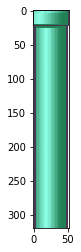

In [179]:
pipe_path = "/content/FlappyBird/assets/sprites/pipe-green.png"
plt.figure(figsize = (4, 4))
plt.imshow(cv2.imread(pipe_path))
plt.show()

In [0]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator
    game_state = GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    x_t = x_t / 255.0

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4

    
    if args['mode'] == 'Run':
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))


        x_t1 = x_t1 / 255.0


        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)

            #Now we do the experience replay
            state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
            state_t = np.concatenate(state_t)
            state_t1 = np.concatenate(state_t1)
            targets = model.predict(state_t)
            Q_sa = model.predict(state_t1)
            targets[range(BATCH), action_t] = reward_t + GAMMA*np.max(Q_sa, axis=1)*np.invert(terminal)

            loss += model.train_on_batch(state_t, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [0]:
def playGame(args):
    model = buildmodel()
    trainNetwork(model,args)

def main():
    parser = argparse.ArgumentParser(description='Description of your program')
    parser.add_argument('-m','--mode', help='Train / Run', required=True)
    args = vars(parser.parse_args())
    playGame(args)

In [183]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
args = {"mode":"train"}
playGame(args)

Now we build the model...
We finish building the model


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


TIMESTEP 1 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 2 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 3 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 4 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
TIMESTEP 5 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 6 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 7 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 8 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 9 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 10 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 11 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
TIMESTEP 12 / STAT

KeyboardInterrupt: ignored